In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm


REBUILD_DATA = True

class DogsVsCats():
    imageSize = 50
    cats = "CatsVsDogs/PetImages/Cat"
    dogs = "CatsVsDogs/PetImages/Dog"
    labels = {cats : 0, dogs : 1}
    trainingData = []
    catCount = 0
    dogCount = 0
    
    
    def makeTrainingData(self):
        for label in self.labels:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.imageSize, self.imageSize))
                    # np.eye(2).... will produce [0,1] or [1,0]
                    self.trainingData.append([np.array(img), np.eye(2)[self.labels[label]]])
                    # Here we are using hot vectors (like bitmask if second is one it's a dog)
                    if label == self.cats:
                        self.catCount += 1
                    elif label == self.dogs:
                        self.dogCount += 1
                except Exception as e:
                    #print(str(e))
                    pass # if some images are corrupted or not working
        np.random.shuffle(self.trainingData)
        np.save("trainingData.npy", self.trainingData)
        print("Cats:", self.catCount)
        print("Dogs:", self.dogCount)
        
        
if REBUILD_DATA:
    dogsVsCats = DogsVsCats()
    dogsVsCats.makeTrainingData()

  1%|▌                                                                             | 94/12501 [00:00<00:13, 932.87it/s]

CatsVsDogs/PetImages/Cat


  1%|▍                                                                             | 76/12501 [00:00<00:16, 732.71it/s]

CatsVsDogs/PetImages/Dog


100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:14<00:00, 849.62it/s]


Cats: 12476
Dogs: 12470


In [9]:
trainingData = np.load("trainingData.npy", allow_pickle = True)


In [10]:
print(len(trainingData))

24946


In [11]:
print(trainingData[0])

[array([[213, 215, 218, ..., 203, 201, 200],
       [214, 215, 217, ..., 203, 202, 199],
       [215, 217, 218, ..., 203, 202, 200],
       ...,
       [168, 173, 167, ..., 176, 174, 163],
       [165, 171, 173, ..., 178, 176, 175],
       [168, 175, 175, ..., 188, 188, 181]], dtype=uint8)
 array([1., 0.])]


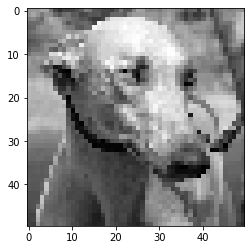

In [14]:
import matplotlib.pyplot as plt

plt.imshow(trainingData[1][0], cmap="gray")
plt.show()